In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.convnext import preprocess_input
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import recall_score,precision_score,f1_score,confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    preprocessing_function=preprocess_input,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2, 0.9],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train_data",
    shuffle = True,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    seed=42,
    subset='training',
    # Use the training subset
)

validation_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train_data",
    shuffle = False,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    seed=42,
    subset='validation'  # Use the validation subset
)

Found 7537 images belonging to 10 classes.
Found 2510 images belonging to 10 classes.


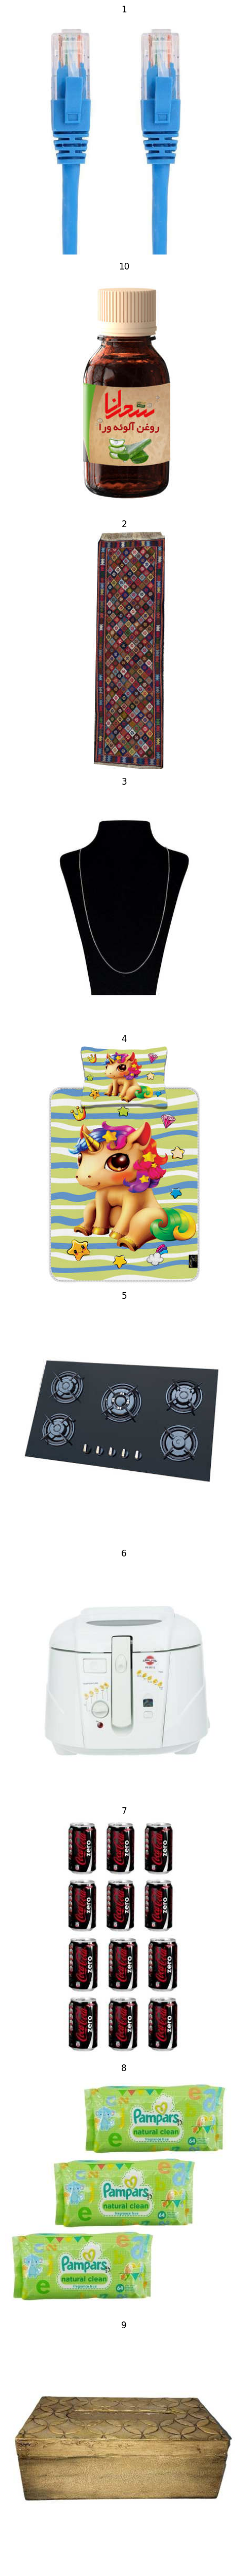

In [6]:
fig = plt.figure(figsize=(100,50))
counter = 0
filenames = validation_generator.filenames
for class_name, class_index in validation_generator.class_indices.items():
    class_samples = [filename for filename in filenames if class_name in filename]
    sample_index = np.random.randint(0, len(class_samples))
    sample_filename = class_samples[sample_index]
    sample_image = plt.imread('/content/drive/MyDrive/train_data' + '/' + sample_filename)
    ax = fig.add_subplot(10,1,counter+1)
    ax.imshow(sample_image)
    ax.axis('off')
    ax.set_title(class_name)
    counter += 1
    if counter >= 10:
        break
plt.tight_layout()
plt.show()

In [14]:
model = keras.applications.ConvNeXtLarge(input_shape=(224,224,3),classes=10, weights="imagenet", include_top=False)
for layer in model.layers:
    layer.trainable = False
flatten = keras.layers.Flatten()(model.output)
xx=keras.layers.Dense(units=1000, activation='relu',kernel_regularizer=l2(1e-3))(flatten)
x = keras.layers.Dense(units=10, activation='softmax',kernel_regularizer=l2(1e-3))(xx)
model_cnxl = keras.models.Model(model.input, x)
model_cnxl.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 convnext_large_prestem_nor  (None, 224, 224, 3)          0         ['input_2[0][0]']             
 malization (Normalization)                                                                       
                                                                                                  
 convnext_large_stem (Seque  (None, 56, 56, 192)          9792      ['convnext_large_prestem_norma
 ntial)                                                             lization[0][0]']              
                                                                                            

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.994718 to fit



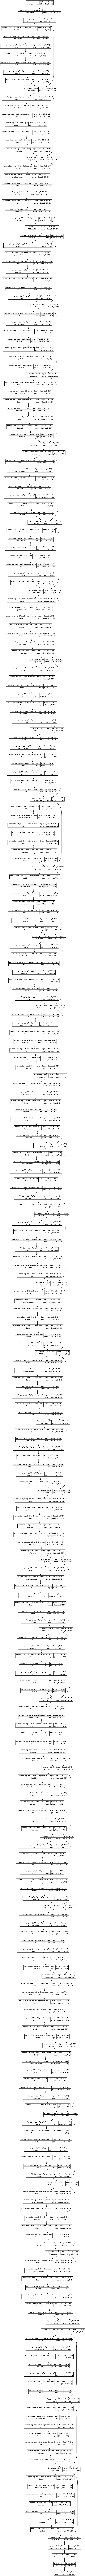

In [15]:
keras.utils.plot_model(model_cnxl, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
model_cnxl.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1e-3),
              metrics='accuracy')

In [17]:
lr_pl=ReduceLROnPlateau(monitor="val_accuracy",patience=3,min_delta=0.01,factor=0.048)
train_cnxl = model_cnxl.fit(train_generator,validation_data=validation_generator,epochs=18,callbacks=[lr_pl])

Epoch 1/18
472/472 [==============================] - 2257s 5s/step - loss: 3.7387 - accuracy: 0.5419 - val_loss: 3.3594 - val_accuracy: 0.5936 - lr: 0.0010
Epoch 2/18
472/472 [==============================] - 348s 737ms/step - loss: 3.0907 - accuracy: 0.6493 - val_loss: 3.1180 - val_accuracy: 0.6163 - lr: 0.0010
Epoch 3/18
472/472 [==============================] - 408s 863ms/step - loss: 2.6000 - accuracy: 0.6821 - val_loss: 2.4666 - val_accuracy: 0.6339 - lr: 0.0010
Epoch 4/18
472/472 [==============================] - 348s 736ms/step - loss: 2.0799 - accuracy: 0.7120 - val_loss: 2.2346 - val_accuracy: 0.6594 - lr: 0.0010
Epoch 5/18
472/472 [==============================] - 348s 736ms/step - loss: 1.8643 - accuracy: 0.7269 - val_loss: 2.1865 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 6/18
472/472 [==============================] - 407s 863ms/step - loss: 1.6844 - accuracy: 0.7399 - val_loss: 2.0351 - val_accuracy: 0.6570 - lr: 0.0010
Epoch 7/18
472/472 [============================

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

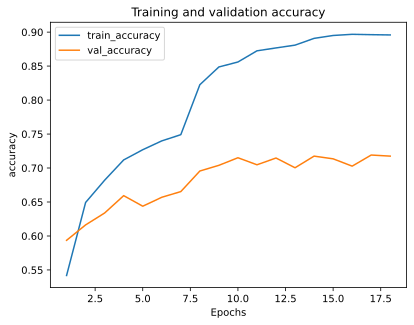

In [20]:
plot_metric(train_cnxl , 'loss')
plot_metric(train_cnxl , 'accuracy')

In [21]:
cnxl=model_cnxl.to_json()#
with open("/content/drive/MyDrive/ConvNeXtLarge_finall_nor.json",'w') as json_file:
  json_file.write(cnxl)

model_cnxl.save_weights("/content/drive/MyDrive/ConvNeXtLarge_finall_nor.h5")
print(":))))))))))")

:))))))))))


In [22]:
train_cnxl.history['loss']

[3.7386651039123535,
 3.090693950653076,
 2.600048542022705,
 2.0798897743225098,
 1.8642820119857788,
 1.6844464540481567,
 1.6071560382843018,
 1.3235368728637695,
 1.1891165971755981,
 1.1353888511657715,
 1.0428540706634521,
 0.9900537133216858,
 0.9395576119422913,
 0.9020723104476929,
 0.8840892910957336,
 0.8825904726982117,
 0.8851780891418457,
 0.8849084973335266]

In [23]:
train_cnxl.history['val_loss']

[3.3594002723693848,
 3.118035316467285,
 2.4666411876678467,
 2.2345852851867676,
 2.1864964962005615,
 2.035093307495117,
 1.9224196672439575,
 1.7756403684616089,
 1.7202072143554688,
 1.6544468402862549,
 1.6278783082962036,
 1.593625545501709,
 1.5983952283859253,
 1.5527215003967285,
 1.5352193117141724,
 1.571895718574524,
 1.5603471994400024,
 1.5395833253860474]

In [24]:
train_cnxl.history['accuracy']

[0.5418601632118225,
 0.6493299603462219,
 0.6821016073226929,
 0.7119543552398682,
 0.7269470691680908,
 0.7399495840072632,
 0.7491044402122498,
 0.822608470916748,
 0.8487461805343628,
 0.8560435175895691,
 0.872495710849762,
 0.8767414093017578,
 0.8808544278144836,
 0.8908053636550903,
 0.8950510621070862,
 0.8967759013175964,
 0.8962451815605164,
 0.8958471417427063]

In [25]:
train_cnxl.history['val_accuracy']

[0.5936254858970642,
 0.6163346767425537,
 0.6338645219802856,
 0.6593625545501709,
 0.6438246965408325,
 0.6569721102714539,
 0.6653386354446411,
 0.6956175565719604,
 0.7039840817451477,
 0.7151394486427307,
 0.7047808766365051,
 0.714741051197052,
 0.7003983855247498,
 0.7175298929214478,
 0.7135457992553711,
 0.7027888298034668,
 0.7191234827041626,
 0.7175298929214478]

In [26]:
y_pred=model_cnxl.predict(validation_generator)
val_lable=np.argmax(y_pred,axis=1)
val_true_labels = validation_generator.classes


157/157 [==============================] - 101s 594ms/step


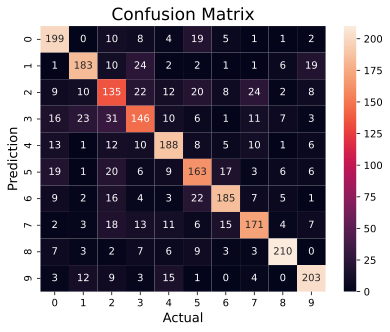

In [27]:
import seaborn as sns
cm = confusion_matrix(val_true_labels,val_lable)
sns.heatmap(cm,
            annot=True,
            fmt='g', )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [28]:
f_score = f1_score(val_true_labels, val_lable, average='weighted')
f_score

0.7106781238502676

In [29]:
recall= recall_score(val_true_labels, val_lable, average='weighted')
recall

0.7103585657370518

In [30]:
precision= precision_score(val_true_labels, val_lable, average='weighted')
precision

0.7120097939967639

In [31]:
test_datagenerator = ImageDataGenerator(preprocessing_function=preprocess_input
                                        ,featurewise_center=True
                                        , featurewise_std_normalization=True)


test_generator=test_datagenerator.flow_from_directory(
    "/content/drive/MyDrive/test",
    target_size=(224,224),
    shuffle=False,
    batch_size=1,
    class_mode=None

)

Found 4000 images belonging to 1 classes.


In [ ]:
#model_cnxl.load_weights('/content/drive/MyDrive/ConvNeXtLarge_1.h5')

In [32]:
y_pred=model_cnxl.predict(test_generator)

4000/4000 [==============================] - 324s 80ms/step


In [33]:
name=test_generator.filenames
label=np.argmax(y_pred,axis=1)+1

In [42]:
t=pd.DataFrame({'name':name,'label':label})
t.to_csv('test_1_nor.csv')


In [41]:
t

name  label
0     test_data/0009e12a0edb16b231b73e501366209662a5...      8
1     test_data/00180e2358a45e3028e993b43e483eeee105...      7
2     test_data/0037909953100cdd2c03a30084fa3876e557...      5
3     test_data/006321aee302c253b9b4922138f879508d48...      1
4     test_data/0067178f7669828b3439d0888795b1f3225a...      1
...                                                 ...    ...
3995  test_data/ffac0874d22903dadba619aea38393f77ce6...      3
3996  test_data/ffbe06e96778ca2a0a3f5c56961304bc2d6d...      5
3997  test_data/ffc3f6f05c6da8c4970334083f03d453f5cd...      8
3998  test_data/ffe163763cbd2674e940dcf77af1863174c5...      9
3999  test_data/fff52b3509f8385825e45c627d131b011153...      1

[4000 rows x 2 columns]

from matplotlib import pyplot as plt
t['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
t['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [39]:
t['label'].value_counts()

10    458
5     429
9     422
3     413
7     403
1     391
4     383
8     379
2     364
6     358
Name: label, dtype: int64